# Testing VLS analysis with iodealise input data

Generating input data representative of a cruise crossing through regions with distinct DMS. The spacing of these regions is identical, so in theory DMS analysis should be able to pick out the distance which we're specifying to define how wide these distances are as teh VLS point.

### In each plot the red line is a least squares linear regression fitted to the first half of the data, and the black line is the distance the VLS analysis should be picking out

### Variables:
'value' is the number of data points ion the dataset

'lenth_of_constant' is the number of data points in each group of near-constant DMS values, i.e. between each imaginary biogeochemical boundary crossed bhy teh imaginary ship

'mt_stdev' is the standard deviation used to define the variability around the mean DMS value between each of the imaginary biogeochemical boundaries

In [2]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate as interp
from scipy.stats import truncnorm
from scipy.stats import ttest_ind
import collections as c
import pwlf
import os
import numpy.polynomial.polynomial as poly
from numpy import arange,array,ones,linalg
from pylab import plot,show


In [6]:


def vls(value,lenth_of_constant,mt_stdev):
    no_segments=np.int(value/lenth_of_constant)
    
        #%%
    #values = [10,50,100,300,3000]                                                  # # number of data points (tnum)

    vlslog_list = []
    r2log_list = []
    tlog_list = []
    plog_list = []

    datadict = c.OrderedDict()


    #    plt.figure()
    #    fig = plt.figure()
    tnum = 't_'+str(value)
    datadict[tnum] = {}
    for j in range(1):                                                        # # number of loop repeats (rnum)
        rnum = 'r_'+str(j)
        datadict[tnum][rnum] = {}
    # # # ------------------------------------------------------------------------------------------------------------
        # # RANDOM TEST # #

        def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
            return truncnorm(
                (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

        tmp = [get_truncated_normal(mean=x*10.0, sd=mt_stdev, low=0.0, upp=30).rvs(lenth_of_constant) for x in np.random.rand(no_segments)]
        rand_dms = np.reshape(tmp,no_segments*lenth_of_constant)

        dist_range = get_truncated_normal(mean=1000.0, sd=2.0, low=200.0, upp=3000.0)
    #         rand_dist = dist_range.rvs(value)
        rand_dist = np.zeros(value) +1000.0
        data = pd.DataFrame(np.array([rand_dms,rand_dist]).T, columns = ['DMSsw','distance'])
    #        data = pd.DataFrame(np.array([rand_dms,spatial_res]).T, columns = ['DMSsw','distance'])

    # # # ------------------------------------------------------------------------------------------------------------
        # # SET INPUT PARAMETERS & NO. OF BINS # #

        DMS = data['DMSsw'].to_numpy()                                                  # # select DMS data column
        dist = (data['distance']/1000.0).to_numpy()                                     # # convert distance between measurements to km
        kmCov = np.cumsum(dist)                                                         # # cumulative transect distance
        maxlen = int(np.max(kmCov))                                                     # # max transect length as an integer
        maxbins = int(maxlen/2.2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
    #        halflen = int(maxlen/2)                                                         # # required for later calcs. MSE=0 where bin number > (transect length)/2
    #        interpint = np.arange(1,halflen+2,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)
        interpint = np.arange(1,maxbins+1,1,dtype=np.int)                               # # set range & intervals as: 1km to halflen +2, stepping every 1km. (+1 to create 1 extra bin (because losing bin_0) and +1 to include the max value as the end point = +2)

    # # # ------------------------------------------------------------------------------------------------------------
        # # BIN, INTERPOLATE & MSE # # 

        processed = c.OrderedDict()
        processed['bin_sizes'] = float(maxlen)/interpint 
                                       # # no.of values to be averaged into bin
        for i in np.arange(len(interpint))+1:                                           # # for each bin size ( 1 : max km (rounded), every 1 ) (Can't start at bin_0 as 'bins' should be a positive integer, i.e. from bin_1 onward)
    #            print i
            bin_number = 'bin_'+str(i)                                                  # # set bin_number as bin_ + i
            bin_dms = []                                                                # # empty temporary array
            bin_dist = []                                                               # # empty temporary array
            tempbin = np.array(pd.cut(data.index, i,labels=range(i)))                   # # temporary array for bin steps based on i in data.index
            for i in np.unique(tempbin):                                                # # for i in bin column values i.e. in bin_44, i = 0-43. Set to unique, to remove repetition of values which fill transect length (0,0,0,1,1,1,2,2,2,3,3,3,4,4,4...43,43,43 etc.)
                bin_dms.append(np.nanmean(DMS[np.where(tempbin == i)].astype('float')))       # # append average DMS values for bin
                bin_dist.append(np.nanmean(kmCov[np.where(tempbin == i)].astype('float')))    # # append average distances for bin
            processed[bin_number] = {}
            processed[bin_number]['dms_mean'] = bin_dms                                 # # bin average DMS
            processed[bin_number]['avdist'] = bin_dist                                  # # bin average distance

        print("Transect length:", maxlen, "km")
        print("No. interpolation intervals (BINS):", len(interpint))

        MSE = []

        for i in np.arange(len(interpint)-1)+2:                                         # # loop through bins 2-end inclusive. Start at bin_2, as can't interpolate the single value in bin_1
            # # INTERPOLATION # #
            x = np.array(processed['bin_'+str(i)]['avdist'])
            y = np.array(processed['bin_'+str(i)]['dms_mean'])                          # # DMS values averaged into bins
            interp_rows = np.where((kmCov > np.nanmin(x)) & (kmCov < np.nanmax(x)))[0]
            f = interp.interp1d(x,y)                                                    # # new function interpolate x & y
            DISTinterp = kmCov[interp_rows]
            DMSinterp = f(DISTinterp)                                                   # # use interpolation function returned by 'interp1d'
            # # MEAN SQUARED ERROR # #
            mse = np.nanmean((DMS[interp_rows] - DMSinterp)**2)                                      # # (dms original - dms intp) squared, then averaged to get one value per bin.
            MSE.append(mse)                                                             # # append to list for all bins

    # # # ------------------------------------------------------------------------------------------------------------
        # # PIECEWISE LINEAR REGRESSION - LINEAR # #

        d = processed['bin_sizes'][1:]                                                  # # bin_sizes (minus the last value, as bin_1 not included)
        e = np.array(MSE[:])                                                                         # # mse values for bin_2 to bin_max
        space_lin = np.linspace(d.min(), d.max(), 1000)                                 # # new temp variable for an arbritrary 1000 points, linearly spaced between bin SIZES bin_2 and bin_max         
        my_pwlf = pwlf.PiecewiseLinFit(d, e)                                            # # use pwlf function PiecewiseLinFit

        # # FOR TRUNCATED VLS # #
        #u = d[0:507]                                           # # 197 for 20 km, 297 for 30 km, 397 for 40 km, 497 for 50 km, 997 for 100 km (507 for 51km)
        #v = e[0:507]
        #space_lin = np.linspace(u.min(), u.max(), 1000)                                # # for trunctated VLS
        #my_pwlf = pwlf.PiecewiseLinFit(u, v)                                           # # use pwlf function PiecewiseLinFit

        vls = my_pwlf.fit(2)                                                            # # find fit with prescribed no. of segments (x) (no. segments = no. inflections +1)
        pwlr = my_pwlf.predict(space_lin)                                               # # predicted PWLR

        print('linear VLS = ', vls[1])

        # # Get the slopes
        slopes = my_pwlf.calc_slopes()                                                  # # slope gradients of the two segmented linear regressions
        # # Get my model parameters
        Beta = my_pwlf.beta                                                             # # 3 beta values for the regressions
        # # Calculate the standard errors associated with each beta parameter
        se = my_pwlf.standard_errors()                                                  # # standard error for each beta parameter
        # # Calculate the R^2 value
        rsq = my_pwlf.r_squared()                                                       # # r squared value for the full regression

        # calculate the piecewise R^2 value
        R2values = np.zeros(my_pwlf.n_segments)
        for i in range(my_pwlf.n_segments):
            # segregate the data based on break point locations
            xmin = my_pwlf.fit_breaks[i]
            xmax = my_pwlf.fit_breaks[i+1]
            xtemp = my_pwlf.x_data
            ytemp = my_pwlf.y_data
            indtemp = np.where(xtemp >= xmin)
            xtemp = my_pwlf.x_data[indtemp]
            ytemp = my_pwlf.y_data[indtemp]
            indtemp = np.where(xtemp <= xmax)
            xtemp = xtemp[indtemp]
            ytemp = ytemp[indtemp]

            # predict for the new data
            yhattemp = my_pwlf.predict(xtemp)

            # calculate ssr
            E = yhattemp - ytemp                                                        # # residual vector
            ssr = np.dot(E, E)                                                          # # sum-of-squares of the residuals

            # calculate sst
            ybar = np.ones(ytemp.size) * np.mean(ytemp)                                 # # ybar = mean of vector y
            ydiff = ytemp - ybar
            sst = np.dot(ydiff, ydiff)                                                  # # total sum-of-squares

            R2values[i] = 1.0 - (ssr/sst)                                               # # coefficient of determination (R2)

        print('Segment R-squared values = ', R2values)

   

        d1 = np.log(d)
        e1 = np.log(e)

        z1 = np.polyfit(d1, e1, 4)
        fp1 = np.poly1d(z1)

        xnew1 = np.linspace(d1.min(), d1.max(), 1000)
        ynew1 = fp1(xnew1)

        my_pwlf1 = pwlf.PiecewiseLinFit(d1, e1)
        vls1 = my_pwlf1.fit(2)                                                          
        pwlr1 = my_pwlf1.predict(xnew1)                                            
        vls_inv = np.exp(vls1)

        #---------------------------------------------

        coefs = poly.polyfit(d1, e1, 4)
        ffit = poly.polyval(xnew1, coefs)

        #---------------------------------------------

        pwrbase = -1.5

        d2 = np.power(d,pwrbase)
        e2 = np.power(e,pwrbase)

        z2 = np.polyfit(d2, e2, 1)
        fp2 = np.poly1d(z2)

        xnew2 = np.linspace(d2.min(), d2.max(), 1000)
        ynew2 = fp2(xnew2)

        my_pwlf2 = pwlf.PiecewiseLinFit(d2, e2)
        vls2 = my_pwlf2.fit(2)                                                          
        pwlr2 = my_pwlf2.predict(xnew2)                                            
        vls_pinv = np.power(vls2,(1.0/pwrbase))
    
        datadict[tnum][rnum]['bin_sizes'] = d
        datadict[tnum][rnum]['mse'] = e
        datadict[tnum][rnum]['space_lin'] = space_lin
        datadict[tnum][rnum]['pwlr'] = pwlr
        datadict[tnum][rnum]['vls'] = vls
        datadict[tnum][rnum]['dms'] = rand_dms

        datadict[tnum][rnum]['bin_sizes_log'] = d1
        datadict[tnum][rnum]['mse_log'] = e1
        datadict[tnum][rnum]['space_log'] = xnew1
        datadict[tnum][rnum]['pwlr_log'] = pwlr1
        datadict[tnum][rnum]['vls_log'] = vls1
        datadict[tnum][rnum]['vls_inv'] = vls_inv

        datadict[tnum][rnum]['bin_sizes_pwr'] = d2
        datadict[tnum][rnum]['mse_pwr'] = e2
        datadict[tnum][rnum]['space_pwr'] = xnew2
        datadict[tnum][rnum]['linfit_pwr'] = ynew2
        datadict[tnum][rnum]['pwlr_pwr'] = pwlr2
        datadict[tnum][rnum]['vls_pwr'] = vls2
        datadict[tnum][rnum]['vls_pinv'] = vls_pinv
        
        return datadict[tnum][rnum]['dms'],datadict[tnum][rnum]['bin_sizes'], datadict[tnum][rnum]['mse'],datadict[tnum][rnum]['bin_sizes_log'], datadict[tnum][rnum]['mse_log']
    
    
def plot_vls_data(dms,bin_sizes,mse,bin_sizes_log,mse_log,lenth_of_constant,out_file_name):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))

    ax1.plot(dms, '-', alpha=0.7)

    ax2.plot(bin_sizes,mse, 'o', alpha=0.5)
    #     ax2.plot(np.flip(datadict[tnum][rnum]['mse']), '+', alpha=0.9)

    #     ax2.plot(datadict[tnum][rnum]['space_lin'], datadict[tnum][rnum]['pwlr'], '-', color='k', alpha=0.7)

    ax3.plot(bin_sizes_log,mse_log, 'o', alpha=0.5)
    #     ax2.plot(datadict[tnum][rnum]['space_log'], datadict[tnum][rnum]['pwlr_log'], '-', color='k', alpha=0.7)

    # Linear fit to first half of data
    xi = bin_sizes_log
    loc = np.where(bin_sizes_log < (np.max(bin_sizes_log)/2.0))[0]
    xi = xi[loc]
    A = array([ xi, ones(len(xi))])
    # linearly generated sequence
    y = mse_log[loc]
    w = linalg.lstsq(A.T,y)[0]
    # obtaining the parameters
    # plotting the line
    line = w[0]*bin_sizes_log+w[1]
    # regression line
    #     plot(xi,y,'o')
    ax3.plot(bin_sizes_log,line,'r-')
    
    ymin, ymax = ax3.get_ylim()
    # Plot the actialt VLS value as defined when producing the input data
    ax3.plot([np.log(lenth_of_constant),np.log(lenth_of_constant)],[ymin, ymax],'k')


    xmin, xmax = ax3.get_xlim()
    xticks = np.linspace(xmin,xmax,5)
    ax3.set_xticks(xticks)
    ax3.set_xticklabels(np.exp(xticks).round(2))

    ymin, ymax = ax3.get_ylim()
    yticks = np.linspace(ymin,ymax,5)
    ax3.set_yticks(yticks)
    ax3.set_yticklabels(np.exp(yticks).round(2)) 


    ax1.set_xlabel('distance along transect, km')
    ax1.set_ylabel("DMS 'measurement'")

    ax2.set_xlabel('Bin size')
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title(' Linear data')

    ax1.set_title('input idealised DMS data')
    ax2.set_title('Linear data')
    ax3.set_title(' Log-transformed data')

    ax3.grid(b=None, which='both', axis='both')
    ax3.grid(b=None, which='both', axis='both')


    plt.savefig(out_file_name)

    
    

Transect length: 1000 km
No. interpolation intervals (BINS): 454
linear VLS =  295.14788574062186
Segment R-squared values =  [0.96650552 0.99999978]


<ipython-input-6-fb8c6e2b4535>:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = linalg.lstsq(A.T,y)[0]


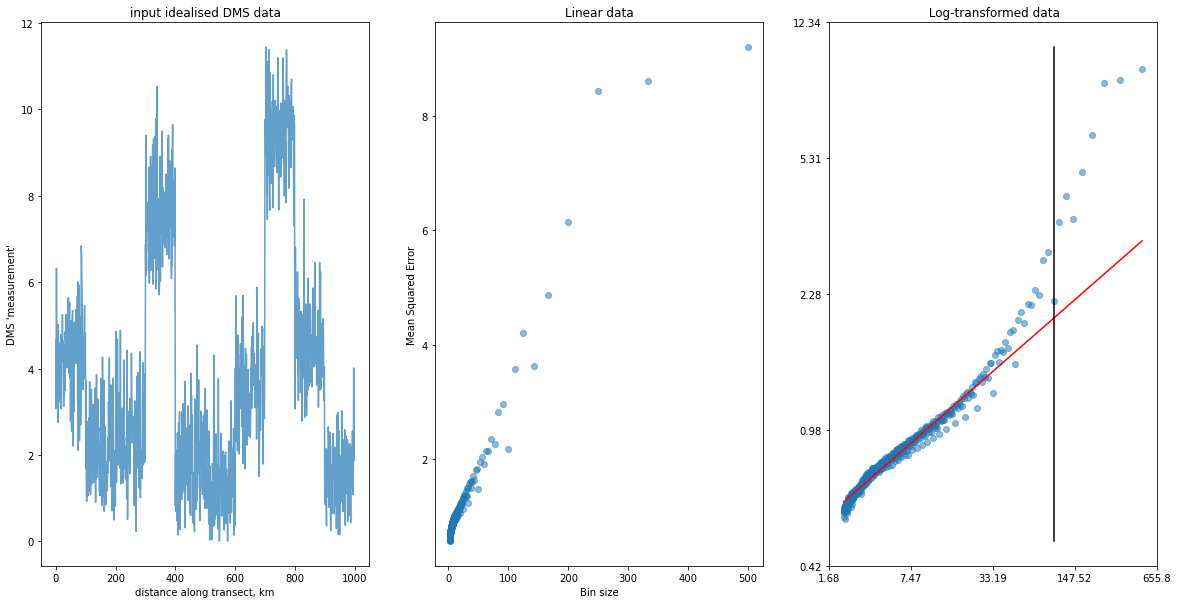

In [8]:
value = 1000   # # number of data points (tnum)
lenth_of_constant=100
mt_stdev = 1.0

dms,bin_sizes,mse,bin_sizes_log,mse_log = vls(value,lenth_of_constant,mt_stdev)

plot_vls_data(dms,bin_sizes,mse,bin_sizes_log,mse_log,lenth_of_constant,'/Users/ph290/Downloads/for_george5.png')

Transect length: 5000 km
No. interpolation intervals (BINS): 2272
linear VLS =  28.98036078156368
Segment R-squared values =  [0.9854639  0.25489205]


<ipython-input-6-fb8c6e2b4535>:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = linalg.lstsq(A.T,y)[0]


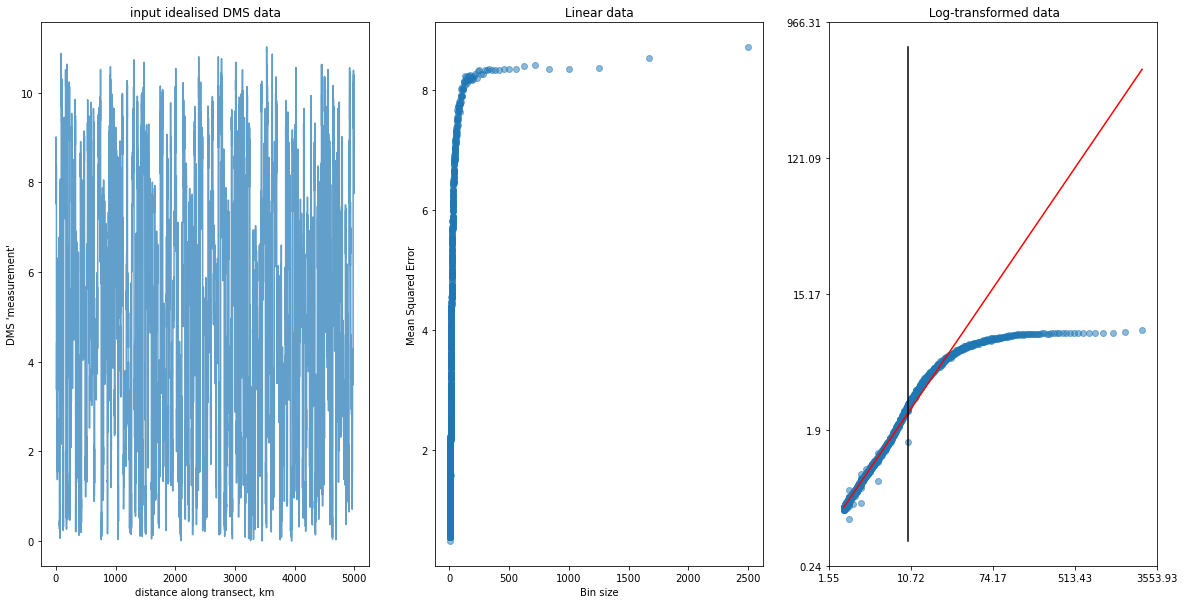

In [9]:
value = 5000   # # number of data points (tnum)
lenth_of_constant=10
mt_stdev = 0.5

dms,bin_sizes,mse,bin_sizes_log,mse_log = vls(value,lenth_of_constant,mt_stdev)

plot_vls_data(dms,bin_sizes,mse,bin_sizes_log,mse_log,lenth_of_constant,'/Users/ph290/Downloads/for_george6.png')

Transect length: 1000 km
No. interpolation intervals (BINS): 454
linear VLS =  25.395225229761262
Segment R-squared values =  [0.97920896 0.48046168]


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/pwlf/pwlf.py:1108: RuntimeWarning: invalid value encountered in double_scalars
  self.slopes[i] = (y_hat[i+1]-y_hat[i]) / \
<ipython-input-6-fb8c6e2b4535>:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = linalg.lstsq(A.T,y)[0]


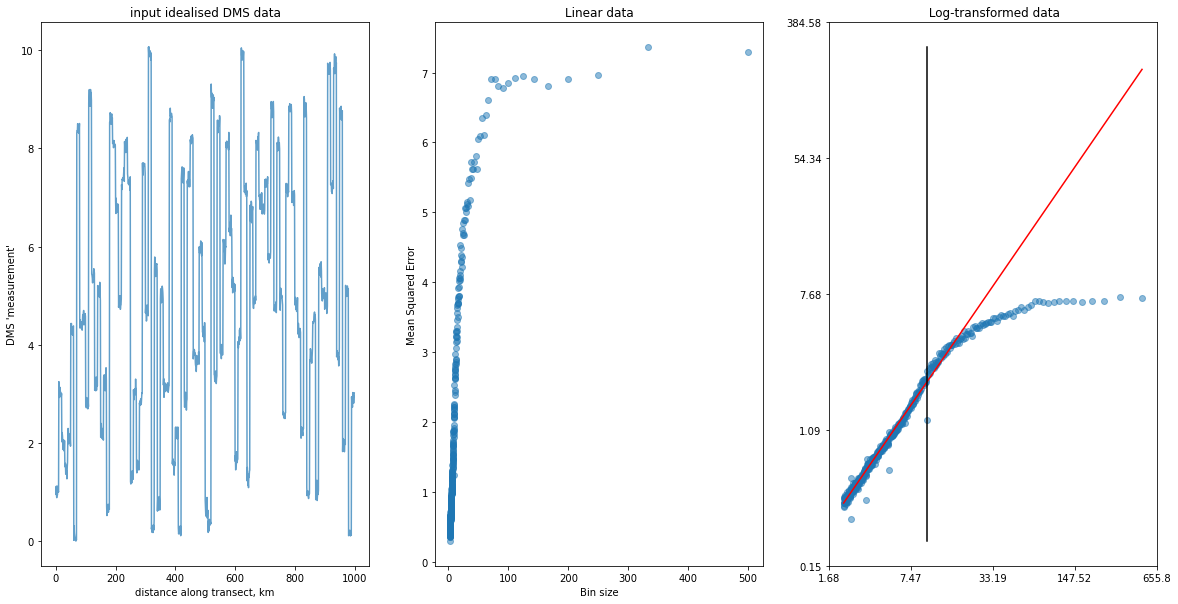

In [10]:
value = 1000   # # number of data points (tnum)
lenth_of_constant=10
mt_stdev = 0.1

dms,bin_sizes,mse,bin_sizes_log,mse_log = vls(value,lenth_of_constant,mt_stdev)

plot_vls_data(dms,bin_sizes,mse,bin_sizes_log,mse_log,lenth_of_constant,'/Users/ph290/Downloads/for_george7.png')

Transect length: 1000 km
No. interpolation intervals (BINS): 454
linear VLS =  28.084307155403767
Segment R-squared values =  [0.98477842 0.31115139]


<ipython-input-6-fb8c6e2b4535>:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = linalg.lstsq(A.T,y)[0]


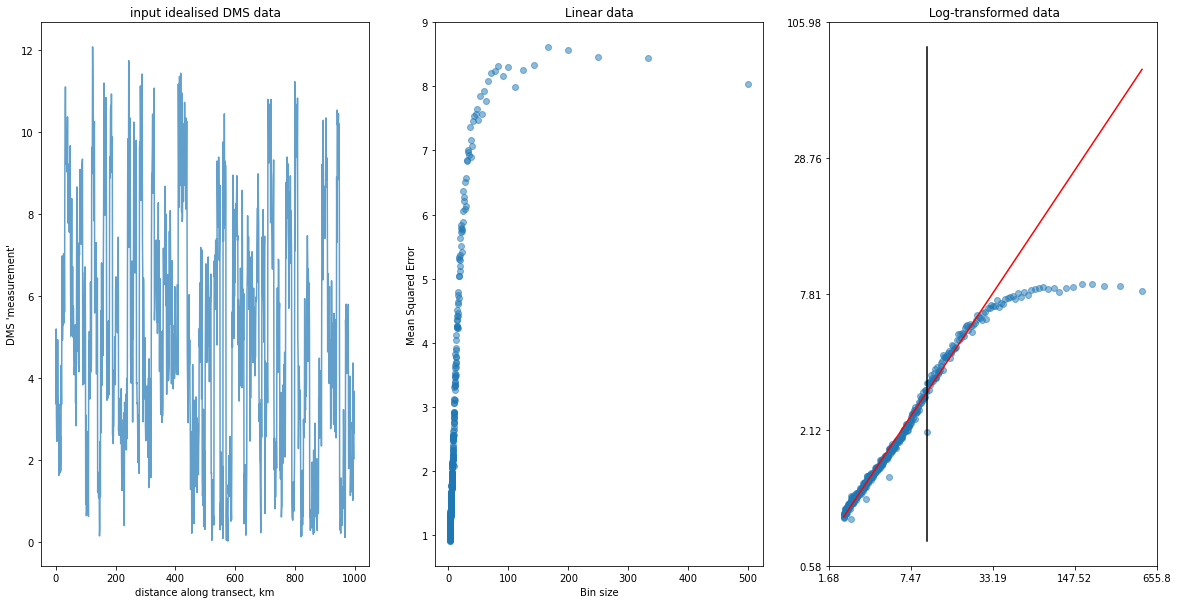

In [13]:
value = 1000   # # number of data points (tnum)
lenth_of_constant=10
mt_stdev = 1.0

dms,bin_sizes,mse,bin_sizes_log,mse_log = vls(value,lenth_of_constant,mt_stdev)

plot_vls_data(dms,bin_sizes,mse,bin_sizes_log,mse_log,lenth_of_constant,'/Users/ph290/Downloads/for_george8.png')

In [ ]:
value = 10000   # # number of data points (tnum)
lenth_of_constant=100
mt_stdev = 0.5

dms,bin_sizes,mse,bin_sizes_log,mse_log = vls(value,lenth_of_constant,mt_stdev)

plot_vls_data(dms,bin_sizes,mse,bin_sizes_log,mse_log,lenth_of_constant,'/Users/ph290/Downloads/for_george9.png')